# How (Not) to Invest II - The RSI and Stochastic Oscillator
Momentum trading is an interesting approach to short-term trading. It involves a *"strategy to capitalize on the continuance of an existing market trend...(by)...going long stocks, futures, or market ETFs showing upward-trending prices and short the respective assets with downward-trending prices"* ([Investopedia](https://www.investopedia.com/terms/m/momentum_investing.asp)). Two classic indicators of momentum are the Relative Strength Index (RSI) and the Stochastic Oscillator (STO). In this post, I evaluate the effectiveness of simple RSI and STO trading strategies.  
  
# Meet the Indicators
  
## Relative Strength Index (RSI)
The RSI is a momentum oscillator that measures the speed and magnitude of price movements ([StockCharts](https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:relative_strength_index_rsi)). A nice feature about the RSI is that it is bound between 0 and 100. This enables us to set fixed thresholds to indicate when to buy a stock (because it's oversold) and when to sell a stock (because it's overbought). The RSI has three parameters:  
  
1. **Lookback Period:** This the number of days in the past to calculate gains and losses. The traditional setting is 14 periods.  
2. **Oversold Threshold:** This indicates the level at which a stock is considered too low, possibly due to overreaction. In theory, oversold stocks are poised for an upward rebound. The traditional setting is 30.
3. **Overbought Threshold:** This indicates the level at which a stock is considered excessively high. The traditional setting is 70.  
  
## Stochastic Oscillator (STO)
The STO is also a momentum oscillator, and it measures the relative position of the current closing price within the trading range of the past *n* days. For example, if the trading range in the past 14 days was \$10 to \$1000 and the current price is \$700, then the STO would give a reading of about 70 (out of 100). The parameters are the same as the RSI, except that the traditional oversold threshold is 20 and the traditional overbought threshold is 80. Refer to [StockCharts](https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:stochastic_oscillator_fast_slow_and_full) for a more detailed description of the STO.  
  
# Trading Simulation
Next, we run trading simulations to evaluate the effectiveness of the RSI and STO in delivering positive excess returns. 
  
## Evaluation Metrics
I use two metrics to evaluate the strategies:  
  
1. **Annualised Returns:** In my [first post](https://chrischow.github.io/dataandstuff/2018-10-28-how-not-to-invest-macd/), I computed the overall returns from MACD-based trading strategies, which resulted in huge variance due to the different time periods used for the various stocks. Thus, in this post, I annualise returns from the RSI/STO trading strategies and the buy-and-hold benchmark.  
2. **Percentage of Profitable Trades:** This is simply the Precision metric from my first post, but in simpler terms. It measures the proportion of all trades executed by the RSI/STO strategies that were profitable.  
  
## Parameters
I tested the following parameters for both the RSI and STO:  
  
1. **Lookback Period:** 5, 10, 15, and 20
2. **Oversold Threshold:** 10, 20, and 30
3. **Overbought Threshold:** 70, 80, and 90  
  
This amounted to 30 configurations per indicator (RSI/STO).  
  
## Data
We used 493 stocks from the S&P 500 to test the trading strategies. In total, approximately 35,500 simulations were run.

In [1]:
# Import required modules
import fix_yahoo_finance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from sklearn.linear_model import LinearRegression
import warnings
from yahoo_finance import Share

# Settings
warnings.filterwarnings('ignore')

# Override pdr
yf.pdr_override()

# Import stocklist
sp500 = pd.read_csv('sp500.csv')

In [2]:
# Modify settings
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'y'
mpl.rcParams['grid.color'] = '#e8e8e8'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['xtick.color'] = '#494949'
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.color'] = '#494949'
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.edgecolor'] = '#494949'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.labelpad'] = 15
mpl.rcParams['axes.labelcolor'] = '#494949'
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Raleway'
mpl.rcParams['scatter.marker'] = 'h'

# Colours
def get_cols():
    
    print('[Colours]:')
    print('Orange:     #ff9966')
    print('Navy Blue:  #133056')
    print('Light Blue: #b1ceeb')
    print('Green:      #6fceb0')
    print('Red:        #f85b74')

    return

### Helper Functions

In [3]:
# Function for simple moving average
def sma(x, n = 200):
    
    # Copy data
    df = x.copy()
    
    # Calculate rolling mean
    temp_sma = pd.rolling_mean(df.Close, n)
    
    # Output
    return temp_sma
    
# Function for RSI
def rsi(x, n = 14):
    
    # Copy data
    df = x.copy()
    
    # Calculate difference
    df['delta'] = df.Close.diff()
    
    # Calculate gains and losses
    gains = df.delta.copy()
    gains[gains < 0] = 0
    
    losses = df.delta.copy()
    losses[losses > 0] = 0
    
    # Calculate rolling n-day average of gains and losses
    avg_gains = pd.rolling_mean(gains, n)
    avg_losses = pd.rolling_mean(losses, n).abs()
    
    # Calculate relative strength
    rs = avg_gains / avg_losses
    
    # Calculate RSI
    rsi = 100.0 - (100.0 / (1.0 + rs))
    
    # Output
    return(rsi)

# Function for Stochastic Oscillator
def stoch(x, n = 14):
    
    # Copy data
    df = x.copy()
    
    # Calculate %K
    stoch_k = ((df.Close - pd.rolling_min(df.Low, n)) / (pd.rolling_max(df.High, n) - pd.rolling_min(df.Low, n))) * 100
    
    # Output
    return stoch_k

# Function for trading simulations
def sim_trade(close, buy_signal, sell_signal, sma_filter, indicator, bah, verbose = False):
    
    # Initialise variables
    BUY_STATE = 0
    BUY_PRICE = 0
    PORTFOLIO_VALUE = 100
    TRADES = 0
    PROFITABLE_TRADES = 0
    RETURNS = []
    
    # Loop through
    for i in np.arange(len(close)):
    
        # Check if stock is trading above SMA-200
        if sma_filter.iloc[i]:
            
            # Check buy state
            if BUY_STATE == 0:

                # If buy signal triggered
                if buy_signal.iloc[i] == 1:

                    # Update buy state
                    BUY_STATE = 1

                    # Save price
                    BUY_PRICE = close.iloc[i].copy()

            else:

                # If sell signal triggered
                if sell_signal.iloc[i] == 1:

                    # Update buy state
                    BUY_STATE = 0
                    
                    # Calculate returns
                    temp_returns = close.iloc[i].copy() / BUY_PRICE
                    
                    # Update portfolio value
                    PORTFOLIO_VALUE = PORTFOLIO_VALUE * temp_returns
                    
                    # Append returns
                    RETURNS.append(temp_returns - 1)

                    # Count trades
                    TRADES += 1

                    # Count profitable trades
                    if close.iloc[i].copy() / BUY_PRICE > 1:

                        PROFITABLE_TRADES += 1
    
    # Compute days
    DAYS = len(close)
    
    # Compute annualised returns
    ANN_BAH = (1 + bah / 100) ** (250 / DAYS) - 1
    ANN_IND = (PORTFOLIO_VALUE / 100) ** (250 / DAYS) - 1
    
    
    # Print
    if verbose:
        print(indicator + ' Returns (Total): ' + '{0:.2f}%'.format(PORTFOLIO_VALUE - 100))
        print(indicator + ' Excess Returns (Total): ' + '{0:.2f}%'.format(PORTFOLIO_VALUE - 100 - bah))
        print(indicator + ' Returns (Annualised): ' + '{0:.2f}%'.format(ANN_IND * 100))
        print(indicator + ' Excess Returns (Annualised): ' + '{0:.2f}%'.format(ANN_IND * 100 - ANN_BAH * 100))
        print(indicator + ' Mean Returns: ' + '{0:.2f}%'.format(np.mean(RETURNS) * 100))
        print(indicator + ' SD Returns: ' + '{0:.2f}%'.format(np.std(RETURNS) * 100))
        print(indicator + ' Trades: ' + str(TRADES))
        print(indicator + ' % Profitable: ' + '{0:.2f}%'.format(PROFITABLE_TRADES / TRADES * 100))
        print()
    
    # Output
    return [PORTFOLIO_VALUE - 100, PORTFOLIO_VALUE - 100 - bah, np.mean(RETURNS) * 100, np.std(RETURNS) * 100,
            TRADES, PROFITABLE_TRADES, DAYS, ANN_IND * 100, ANN_BAH * 100, bah]

# Function to test configurations
def sim_config(stock, all_n = [5, 10, 15, 20], lower = [10, 20, 30], upper = [70, 80, 90]):
    
    # Initialise list
    output = []
    
    # Fix start date and end date
    start_date = '1979-01-01'
    end_date = '2018-06-01'
    
    # Pull data
    orig_df = pdr.get_data_yahoo(stock, start_date, end_date, progress=False)
    
    # Compute SMA-200
    orig_df['sma200'] = sma(orig_df)
    
    # FILTER 1: STOCK IS TRADING ABOVE SMA-200
    orig_df['f1'] = orig_df.Close > orig_df.sma200
    
    # ---- RSI SIMULATIONS ---- #
    # print('Simulating RSI...')
    for rn in all_n:
        for rl in lower:
            for ru in upper:
                
                # Copy data
                temp_df = orig_df.copy()
                
                # Compute RSI
                temp_df['rsi'] = rsi(temp_df, n = rn)
                
                # Trading signals
                temp_df['rsi_buy'] = ((temp_df.rsi.shift(1) < rl) & (temp_df.rsi > rl)).astype(int)
                temp_df['rsi_sell'] = ((temp_df.rsi.shift(1) < ru) & (temp_df.rsi > ru)).astype(int)
                
                # Drop missing values
                temp_df.dropna(axis = 0, inplace = True)
                
                # Compute buy and hold returns
                bah_returns = (temp_df.Close.iloc[-1] / temp_df.Close.iloc[0] - 1) * 100
                
                # Simulate trade
                temp_results = sim_trade(temp_df.Close, temp_df.rsi_buy, temp_df.rsi_sell, temp_df.f1, 'RSI', bah_returns)
                
                # Append stock, settings, and simulation results
                output.append(
                    tuple(
                        [stock, 'rsi', rn, rl, ru] + temp_results
                    )
                )
    
    # ---- STO SIMULATIONS ---- #
    # print('Simulating STO...')
    for sn in all_n:
        for sl in lower:
            for su in upper:
                
                # Copy data
                temp_df = orig_df.copy()
                
                # Compute RSI
                temp_df['sto'] = stoch(temp_df, n = sn)
                
                # Trading signals
                temp_df['sto_buy'] = ((temp_df.sto.shift(1) < sl) & (temp_df.sto > sl)).astype(int)
                temp_df['sto_sell'] = ((temp_df.sto.shift(1) < su) & (temp_df.sto > su)).astype(int)
                
                # Drop missing values
                temp_df.dropna(axis = 0, inplace = True)
                
                # Compute buy and hold returns
                bah_returns = (temp_df.Close.iloc[-1] / temp_df.Close.iloc[0] - 1) * 100
                
                # Simulate trade
                temp_results = sim_trade(temp_df.Close, temp_df.sto_buy, temp_df.sto_sell, temp_df.f1, 'STO', bah_returns)
                
                # Append stock, settings, and simulation results
                output.append(
                    tuple(
                        [stock, 'sto', sn, sl, su] + temp_results
                    )
                )
    
    # Output
    # print('Done!')
    return output

### Run Trade Simulations

In [4]:
# # Initialise data frame for storage
# rsi_stoch_df = pd.DataFrame()
# # rsi_stoch_df = pd.read_csv('rsi_stoch_results.csv')

# # Collect data on all S&P 500 companies
# for i in np.arange(495, len(sp500.Symbol)):
    
#     # Get symbol
#     stk = sp500.Symbol.iloc[i]
    
#     # Update
#     print('Processing [' + str(i) + '] ' + stk + '...', end = '', flush = True)
    
#     # Simulate trades and append results
#     temp_res = sim_config(stk)
    
#     # Convert to df
#     temp_res_df = pd.DataFrame(temp_res, columns = ['stock', 'indicator', 'n', 'lower', 'upper', 'returns', 'exc_returns',
#                                 'mean_returns', 'sd_returns', 'trades', 'prof_trades', 'days', 'ann_returns', 'ann_bah',
#                                 'bah'])
    
#     # Append to data frame
#     rsi_stoch_df = pd.concat([rsi_stoch_df, temp_res_df], axis = 0)
    
#     # Save data
#     rsi_stoch_df.to_csv('rsi_stoch_results.csv', index = False)
    
#     # Calculate excess returns
#     temp_print_df = temp_res_df[['stock', 'indicator', 'ann_returns', 'ann_bah']].copy()
#     temp_print_df['ann_exc'] = temp_print_df.ann_returns - temp_print_df.ann_bah
    
#     # Print
#     print('RSI | STO Excess Returns: ' + '{0:.2f}%'.format(temp_print_df.ann_exc[temp_print_df.indicator == 'rsi'].mean()) + \
#          ' | ' + '{0:.2f}%'.format(temp_print_df.ann_exc[temp_print_df.indicator == 'sto'].mean()))

# Analysis of Results  
In this section, we review the excess returns and percentage of profitable trades from the simulations.

In [5]:
# Load data
rsi_stoch_df = pd.read_csv('rsi_stoch_results.csv')

# Compute annualised excess returns
rsi_stoch_df['ann_exc'] = rsi_stoch_df.ann_returns - rsi_stoch_df.ann_bah

# Compute profitable trades
rsi_stoch_df['profitable_pct'] = rsi_stoch_df.prof_trades / rsi_stoch_df.trades * 100

## Which Performed Better: The RSI or the STO?
The STO exhibited slightly better performance than the RSI. Approximately 11.4% of all STO strategies delivered positive excess returns, compared to 8.6% for RSI strategies. However, **both indicators failed to deliver positive excess returns on average**. An interesting thing to note is that although the STO generated more buy signals, the proportion of trades that were actually profitable as predicted by the STO was comparable to that of the RSI.

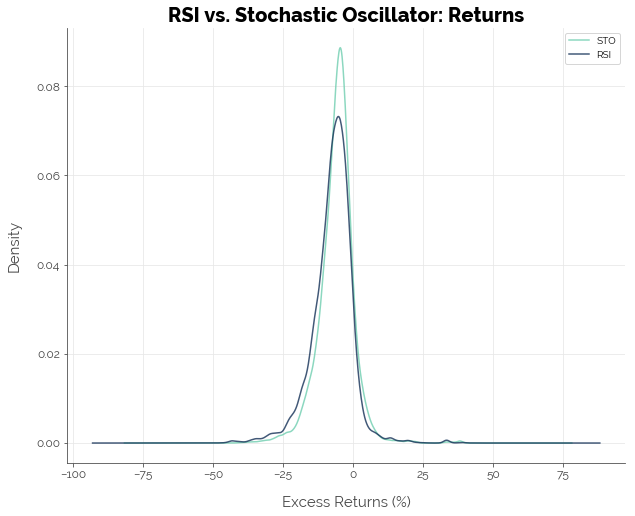

,ann_exc,days,trades,profitable_pct
indicator,,,,
sto,-6.017121,6830.234280,136.760367,75.054938
rsi,-7.609239,6826.818458,47.954868,78.381752


In [6]:
# Plot RSI vs. STO - returns
plt.figure(figsize = (10,8))
rsi_stoch_df.ann_exc[(rsi_stoch_df.indicator == 'sto') & (abs(rsi_stoch_df.ann_exc) < 50)].plot.density(alpha = 0.8, label = 'STO', color = '#6fceb0')
rsi_stoch_df.ann_exc[(rsi_stoch_df.indicator == 'rsi') & (abs(rsi_stoch_df.ann_exc) < 50)].plot.density(alpha = 0.8, label = 'RSI', color = '#133056')
plt.legend()
plt.title('RSI vs. Stochastic Oscillator: Returns', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.xlabel('Excess Returns (%)')
plt.show()

# Summarise and rank by annualised excess returns
rsi_stoch_df[['indicator', 'ann_exc', 'days', 'trades', 'profitable_pct']].groupby(['indicator']).mean().sort_values(by = 'ann_exc', ascending = False)

## Which Setting Performed Best?
  
### Lookback Period (*n*)
In general, there were minor advantages from using a shorter lookback period. However, once again, **all lookback period settings failed to generate positive excess returns on average**.

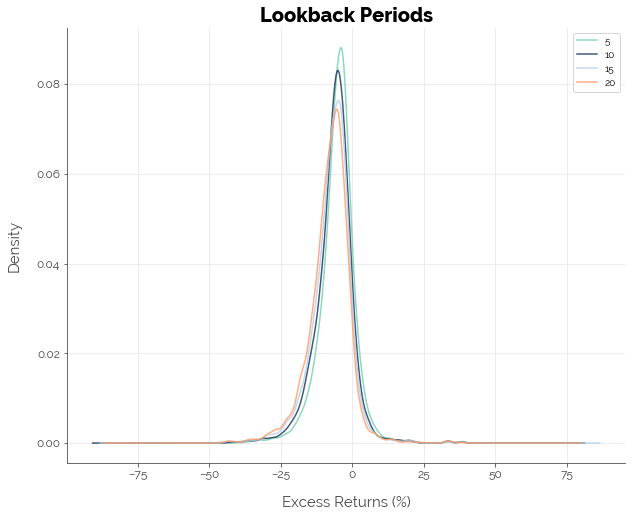

,ann_exc,days,trades,profitable_pct
n,,,,
5,-5.31,6825.26,181.13,73.17
10,-6.55,6829.04,88.43,76.15
15,-7.29,6829.75,57.40,78.45
20,-8.11,6830.05,42.47,79.26


In [7]:
# Plot RSI vs. STO
plt.figure(figsize = (10,8))
rsi_stoch_df.ann_exc[(rsi_stoch_df.n == 5) & (abs(rsi_stoch_df.ann_exc) < 50)].plot.density(alpha = 0.8, label = '5', color = '#6fceb0')
rsi_stoch_df.ann_exc[(rsi_stoch_df.n == 10) & (abs(rsi_stoch_df.ann_exc) < 50)].plot.density(alpha = 0.8, label = '10', color = '#133056')
rsi_stoch_df.ann_exc[(rsi_stoch_df.n == 15) & (abs(rsi_stoch_df.ann_exc) < 50)].plot.density(alpha = 0.8, label = '15', color = '#b1ceeb')
rsi_stoch_df.ann_exc[(rsi_stoch_df.n == 20) & (abs(rsi_stoch_df.ann_exc) < 50)].plot.density(alpha = 0.8, label = '20', color = '#ff9966')
plt.legend()
plt.title('Lookback Periods', fontdict = {'fontweight': 'bold', 'fontsize': 20})
plt.xlabel('Excess Returns (%)')
plt.show()

# Summarise and rank by annualised excess returns
round(rsi_stoch_df[['n', 'indicator', 'ann_exc', 'days', 'trades', 'profitable_pct']].groupby(['n']).mean().sort_values(by = 'ann_exc', ascending = False), 2)

### Thresholds
Like the lookback periods and indicators, average excess returns were negative for all combinations of thresholds (for oversold or overbought signals).

In [8]:
# Create ID for thresholds
rsi_stoch_df['thresh'] = rsi_stoch_df.lower.astype(str) + '-' + rsi_stoch_df.upper.astype(str)

# Summarise and rank by annualised excess returns
round(rsi_stoch_df[['thresh', 'indicator', 'ann_exc', 'days', 'trades', 'profitable_pct']].groupby(['thresh', 'indicator']).mean().sort_values(by = 'ann_exc', ascending = False).head(10), 2)

,,ann_exc,days,trades,profitable_pct
thresh,indicator,,,,
30-90,rsi,-3.00,6826.82,47.03,80.96
20-90,sto,-4.96,6830.23,127.87,75.29
30-90,sto,-5.01,6830.23,146.06,75.77
30-80,rsi,-5.21,6826.82,73.17,77.64
10-90,sto,-5.44,6830.23,99.93,75.63
20-90,rsi,-5.89,6826.82,37.83,80.51
20-80,sto,-5.99,6830.23,142.69,75.19
30-80,sto,-6.14,6830.23,165.62,75.38
10-80,sto,-6.31,6830.23,108.29,75.49


### Combined Settings
When split by the combined settings (lookback period + oversold and overbought thresholds), there was no difference: no configuration could deliver positive excess returns on average. The increase in the percentage of profitable trades was inversely proportionate to the number of trades. This is what we expect: the fewer signals there are, the more spread out they are likely to be; and the longer you hold a stock, the higher the probability that that trade will be profitable.

In [9]:
# Create ID for combined setting
rsi_stoch_df['full_setting'] = rsi_stoch_df.n.astype(str) + '-' \
    + rsi_stoch_df.lower.astype(str) + '-' + rsi_stoch_df.upper.astype(str)

# Summarise and rank by annualised excess returns
round(rsi_stoch_df[['full_setting', 'indicator', 'ann_exc', 'days', 'trades', 'profitable_pct']].groupby(['full_setting', 'indicator']).mean().sort_values(by = 'ann_exc', ascending = False).head(10), 2)

,,ann_exc,days,trades,profitable_pct
full_setting,indicator,,,,
15-30-90,rsi,-1.98,6829.06,9.70,83.13
10-30-90,rsi,-2.76,6827.73,34.70,78.13
5-30-90,sto,-3.15,6829.67,233.58,73.64
5-20-90,sto,-3.23,6829.67,207.22,73.34
5-30-90,rsi,-3.34,6820.85,140.84,73.55
20-30-90,rsi,-3.92,6829.64,2.87,90.08
5-10-90,sto,-3.97,6829.67,160.34,73.38
5-20-90,rsi,-4.24,6820.85,118.02,73.93
5-20-80,sto,-4.63,6829.67,237.98,73.20


## Which Stocks Performed Best?
The stocks given in the table below were stocks on which the trading strategies beat the market. This does not mean that you can simply apply RSI and STO trading strategies to these stocks and expect a profit in the future, because (1) past relationships between the technical indicators and *these* stocks' prices may not persist, and (2) there was something fundamentally wrong with all of these stocks.  
  
First, note how **all** of these stocks had negative buy-and-hold returns. Second, note how there were so few trades across the simulation window for both the RSI and the STO. When we put these pieces of information together, we realise that, chances are, the RSI and STO trading strategies recommended buying these stocks when they were still climbing, selling these stocks at a profit, and making no further buy or sell recommendations. Consequently, these trading strategies achieved a small profit or loss that were larger (in absolute terms) than the buy-and-hold benchmark returns. That explains why the RSI and STO strategies looked good on these stocks.  
  
Using this new information by considering only stocks that had *positive buy-and-hold returns*, we can revise our previous statistics on the percentage of RSI and STO trading strategies that delivered positive excess returns from 8.6% and 11.4% to **6.2%** and **9.1%** respectively.

In [10]:
# Summarise and rank by annualised excess returns
round(rsi_stoch_df[['stock', 'indicator', 'ann_exc', 'ann_returns', 'ann_bah', 'trades', 'days']].groupby(['stock', 'indicator']).mean().sort_values(by = 'ann_exc', ascending = False).head(10), 2)

ann_exc  ann_returns  ann_bah  trades    days
stock indicator                                               
UA    sto          36.22         2.90   -33.32    0.83   531.0
      rsi          34.28         0.96   -33.32    0.31   531.0
KHC   sto          17.39         3.92   -13.47    8.92   534.0
EVHC  rsi          17.31        -2.25   -19.56    3.39  1009.0
      sto          15.99        -3.57   -19.56   10.36  1009.0
KHC   rsi          14.79         1.32   -13.47    2.50   534.0
NAVI  sto          11.11         0.59   -10.51   10.83   839.0
      rsi          10.97         0.46   -10.51    4.61   839.0
COTY  rsi           8.33         5.44    -2.89    6.58  1052.0
JNPR  rsi           8.18        -0.31    -8.49   24.00  4565.0

# Conclusion [TLDR]

In conclusion, we found no evidence that the RSI and STO trading strategies could beat the buy-and-hold benchmark. The STO generated more buy/sell signals and performed slightly better than the RSI. However, both performed poorly on absolute terms: only 6.2% of RSI trading strategies and 9.1% of STO trading strategies for **stocks with a positive buy-and-hold return** generated positive excess returns.